In [245]:
import sys
import os

# Add the project root directory to sys.path
project_root = r'C:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model'
if project_root not in sys.path:
    sys.path.append(project_root)

In [246]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from aws.s3_utils import save_dataframe_to_s3, load_dataframe_from_s3, save_model_to_s3, load_model_from_s3
from sklearn.preprocessing import OneHotEncoder


In [247]:
df = load_dataframe_from_s3('data/box_scores/current.parquet')
df2 = load_dataframe_from_s3('data/box_scores/2024-2025.parquet')
df3 = load_dataframe_from_s3('data/box_scores/2023-2024.parquet')
df4 = load_dataframe_from_s3('data/box_scores/2022-2023.parquet')
df = pd.concat([df, df2, df3, df4])

# Validate box scores data structure
required_box_score_cols = ['PLAYER', 'GAME_DATE', 'FP', 'Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'MIN', 'MATCHUP']
missing_cols = [col for col in required_box_score_cols if col not in df.columns]
if missing_cols:
    error_msg = f"Missing required columns in box scores data: {missing_cols}"
    print(error_msg)

if 'MIN' in df.columns:
    original_count = len(df)
    df = df[df['MIN'] != 0]
    print(f"Filtered from {original_count} to {len(df)} records (MIN != 0)")

print(df.head())

Filtered from 78602 to 78307 records (MIN != 0)
  SEASON_ID PLAYER_ID     TEAM_ID TEAM_ABBREVIATION      PLAYER TEAM  \
0     22024   1630639  1610612761               TOR  Toronto Raptors   
1     22024   1630639  1610612761               TOR  Toronto Raptors   
2     22024   1630639  1610612761               TOR  Toronto Raptors   
3     22024   1630639  1610612761               TOR  Toronto Raptors   
4     22024   1630639  1610612761               TOR  Toronto Raptors   

      GAME_ID  GAME_DATE      MATCHUP WL MIN  ... PTS PLUS_MINUS   FP  \
0  0022400397 2024-12-23    TOR @ NYK  L   4  ...   3          5  3.0   
1  0022400414 2024-12-26    TOR @ MEM  L   5  ...   6         -4  8.4   
2  0022400449 2024-12-31    TOR @ BOS  L   4  ...   0         -8  1.2   
3  0022400608 2025-01-21  TOR vs. ORL  W   1  ...   2         -3  2.0   
4  0022400816 2025-02-23  TOR vs. PHX  W   1  ...   0          0  1.2   

  VIDEO_AVAILABLE       PLAYER  CLUSTER Last3_FP_Avg Last5_FP_Avg  \
0          

C:\conda_tmp\ipykernel_24780\1694395540.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df2, df3, df4])


In [248]:
players_df = load_dataframe_from_s3('data/advanced_player_stats/current.parquet')
players_df2 = load_dataframe_from_s3('data/box_scores/2024-2025.parquet')
players_df3 = load_dataframe_from_s3('data/box_scores/2023-2024.parquet')
players_df4 = load_dataframe_from_s3('data/box_scores/2022-2023.parquet')
players_df = pd.concat([players_df, players_df2, players_df3, players_df4])
clustered_players_df = load_dataframe_from_s3('data/clustered_players/current.parquet')

# Use a left merge to add the 'CLUSTER' column to players_df
dataset_clusters = pd.merge(players_df, clustered_players_df[['PLAYER', 'CLUSTER']], on='PLAYER', how='left')

print(dataset_clusters.head())

  STAT_TYPE SCRAPED_DATE SOURCE SEASON_ID  PLAYER_ID       TEAM_ID  \
0       NaN          NaN    NaN     22024  1630639.0  1.610613e+09   
1       NaN          NaN    NaN     22024  1630639.0  1.610613e+09   
2       NaN          NaN    NaN     22024  1630639.0  1.610613e+09   
3       NaN          NaN    NaN     22024  1630639.0  1.610613e+09   
4       NaN          NaN    NaN     22024  1630639.0  1.610613e+09   

  TEAM_ABBREVIATION      PLAYER TEAM     GAME_ID  GAME_DATE  ... PLUS_MINUS  \
0               TOR  Toronto Raptors  0022400397 2024-12-23  ...        5.0   
1               TOR  Toronto Raptors  0022400414 2024-12-26  ...       -4.0   
2               TOR  Toronto Raptors  0022400449 2024-12-31  ...       -8.0   
3               TOR  Toronto Raptors  0022400608 2025-01-21  ...       -3.0   
4               TOR  Toronto Raptors  0022400816 2025-02-23  ...        0.0   

    FP  VIDEO_AVAILABLE       PLAYER  CLUSTER_x  Last3_FP_Avg  Last5_FP_Avg  \
0  3.0              1.0  

In [249]:
dataset_clusters.head(10)

,STAT_TYPE,SCRAPED_DATE,SOURCE,SEASON_ID,PLAYER_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER TEAM,GAME_ID,GAME_DATE,...,PLUS_MINUS,FP,VIDEO_AVAILABLE,PLAYER,CLUSTER_x,Last3_FP_Avg,Last5_FP_Avg,Last7_FP_Avg,Season_FP_Avg,CLUSTER_y
0,NaN,NaN,NaN,22024,1630639.0,1.610613e+09,TOR,Toronto Raptors,0022400397,2024-12-23,...,5.0,3.0,1.0,a.j. lawson,13.0,3.000000,3.00,3.000000,3.000000,4.0
1,NaN,NaN,NaN,22024,1630639.0,1.610613e+09,TOR,Toronto Raptors,0022400414,2024-12-26,...,-4.0,8.4,1.0,a.j. lawson,13.0,5.700000,5.70,5.700000,5.700000,4.0
2,NaN,NaN,NaN,22024,1630639.0,1.610613e+09,TOR,Toronto Raptors,0022400449,2024-12-31,...,-8.0,1.2,1.0,a.j. lawson,13.0,4.200000,4.20,4.200000,4.200000,4.0
3,NaN,NaN,NaN,22024,1630639.0,1.610613e+09,TOR,Toronto Raptors,0022400608,2025-01-21,...,-3.0,2.0,1.0,a.j. lawson,13.0,3.866667,3.65,3.650000,3.650000,4.0
4,NaN,NaN,NaN,22024,1630639.0,1.610613e+09,TOR,Toronto Raptors,0022400816,2025-02-23,...,0.0,1.2,1.0,a.j. lawson,13.0,1.466667,3.16,3.160000,3.160000,4.0
5,NaN,NaN,NaN,22024,1630639.0,1.610613e+09,TOR,Toronto Raptors,0022400870,2025-03-02,...,16.0,-1.0,1.0,a.j. lawson,13.0,0.733333,2.36,2.466667,2.466667,4.0
6,NaN,NaN,NaN,22024,1630639.0,1.610613e+09,TOR,Toronto Raptors,0022400883,2025-03-04,...,-8.0,22.9,1.0,a.j. lawson,13.0,7.700000,5.26,5.385714,5.385714,4.0
7,NaN,NaN,NaN,22024,1630639.0,1.610613e+09,TOR,Toronto Raptors,0022400905,2025-03-07,...,14.0,14.1,1.0,a.j. lawson,13.0,12.000000,7.84,6.971429,6.475000,4.0
8,NaN,NaN,NaN,22024,1630639.0,1.610613e+09,TOR,Toronto Raptors,0022400915,2025-03-08,...,-8.0,16.6,1.0,a.j. lawson,13.0,17.866667,10.76,8.142857,7.600000,4.0
9,NaN,NaN,NaN,22024,1630639.0,1.610613e+09,TOR,Toronto Raptors,0022400932,2025-03-10,...,15.0,48.4,1.0,a.j. lawson,13.0,26.366667,20.20,14.885714,11.680000,4.0


In [250]:
# clusterDict = {}
df.describe()

,GAME_DATE,FG_PCT,FG3_PCT,FT_PCT,FP,CLUSTER,Last3_FP_Avg,Last5_FP_Avg,Last7_FP_Avg,Season_FP_Avg
count,78307,74400.000000,61816.000000,43228.000000,78307.000000,61117.000000,78307.000000,78307.000000,78307.000000,78307.000000
mean,2024-01-18 03:31:57.207912448,0.462133,0.335594,0.767472,21.704822,7.113078,21.586274,21.505656,21.443834,20.921622
min,2022-10-18 00:00:00,0.000000,0.000000,0.000000,-3.500000,0.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,2023-02-28 00:00:00,0.333000,0.000000,0.500000,9.900000,3.000000,11.500000,11.800000,11.857143,11.950000
50%,2024-01-20 00:00:00,0.474000,0.333000,0.857000,19.700000,7.000000,19.900000,19.840000,19.757143,19.225000
75%,2024-12-02 00:00:00,0.600000,0.500000,1.000000,31.300000,10.000000,30.000000,29.700000,29.485714,28.283333
max,2025-04-13 00:00:00,1.000000,1.000000,1.000000,105.200000,14.000000,89.266667,80.740000,75.671429,72.200000
std,NaN,0.239236,0.288643,0.281915,14.986318,3.894061,13.093938,12.654407,12.454016,11.867607


In [251]:
# # Map the 'Cluster' column from clusterdf to the dataset based on 'Player'
# clusterDict = dataset_clusters.set_index('PLAYER')['CLUSTER'].to_dict()

# # Map the 'CLUSTER' column in the dataset
# df['CLUSTER'] = df['PLAYER'].map(clusterDict)

In [252]:
# Remove players without a cluster
# df = df.dropna(subset=['CLUSTER'])
df.sort_values(by=['GAME_DATE'], ascending = [False], inplace=True)
print(df['CLUSTER'].value_counts(dropna=False))


CLUSTER
NaN     17190
3.0      7309
7.0      6947
8.0      5917
10.0     5663
11.0     4217
1.0      4177
14.0     4091
2.0      3974
4.0      3777
9.0      3521
13.0     3360
6.0      3307
5.0      3031
12.0     1579
0.0       247
Name: count, dtype: int64


In [253]:
print("Data type:", df['MIN'].dtype)
df['MIN'] = pd.to_numeric(df['MIN'], errors='coerce')
print("Data type:", df['MIN'].dtype)
print(df['MIN'].head(10))
df['MIN'] = df['MIN'] + np.random.uniform(-5, 5, size=len(df))
df['MIN'] = df['MIN'].clip(lower=0)
df['MIN']

Data type: object
Data type: int64
16894    35
6995     25
12243    12
6823     36
2897     38
22896    43
12170    17
21301    29
6893     24
680      15
Name: MIN, dtype: int64


16894    33.786285
6995     24.515233
12243     7.524229
6823     33.331957
2897     35.737323
           ...    
23790    35.911435
15228    25.867411
4002      2.869210
21713    32.928175
12307    39.695317
Name: MIN, Length: 78307, dtype: float64

In [254]:
# Replace NaN with a placeholder before encoding
df['CLUSTER'] = df['CLUSTER'].fillna('CLUSTER_NAN')

# Parse MATCHUP to extract home/away and opponent
def parse_matchup(matchup_str):
    if pd.isna(matchup_str):
        return 0, 'UNKNOWN'
    matchup_str = str(matchup_str)
    if ' @ ' in matchup_str:
        # Away game: "TOR @ NYK"
        teams = matchup_str.split(' @ ')
        return 0, teams[1] if len(teams) > 1 else 'UNKNOWN'
    elif ' vs. ' in matchup_str:
        # Home game: "TOR vs. PHX" 
        teams = matchup_str.split(' vs. ')
        return 1, teams[1] if len(teams) > 1 else 'UNKNOWN'
    else:
        return 0, 'UNKNOWN'

# Apply parsing
matchup_parsed = df['MATCHUP'].apply(parse_matchup)
df['IS_HOME'] = matchup_parsed.apply(lambda x: x[0])
df['OPPONENT'] = matchup_parsed.apply(lambda x: x[1])

print(f"Parsed MATCHUP: {(df['IS_HOME'] == 1).sum()} home games, {(df['IS_HOME'] == 0).sum()} away games")

# Calculate rest days first
from datetime import datetime, timezone, timedelta
import pytz

def calculate_rest_days(df):
    """Calculate rest days for each player based on their previous game"""
    # Create a copy to avoid modifying the original
    df_sorted = df.copy()
    
    # Ensure GAME_DATE is datetime
    df_sorted['GAME_DATE'] = pd.to_datetime(df_sorted['GAME_DATE'])
    
    # Sort by player and game date (ascending for proper calculation)
    df_sorted = df_sorted.sort_values(['PLAYER', 'GAME_DATE'])
    
    # Calculate days since last game for each player
    df_sorted['PREV_GAME_DATE'] = df_sorted.groupby('PLAYER')['GAME_DATE'].shift(1)
    df_sorted['REST_DAYS'] = (df_sorted['GAME_DATE'] - df_sorted['PREV_GAME_DATE']).dt.days - 1
    
    # For first games (no previous game), set rest days to 3 (reasonable default)
    df_sorted['REST_DAYS'] = df_sorted['REST_DAYS'].fillna(3).astype(int)
    
    # For predictions (current games), calculate rest days from most recent game to today
    # Get current date in ET timezone
    et_tz = pytz.timezone('America/New_York')
    today = datetime.now(et_tz).date()
    
    # Get most recent game for each player
    most_recent_games = df_sorted.groupby('PLAYER')['GAME_DATE'].max().reset_index()
    most_recent_games['MOST_RECENT_DATE'] = most_recent_games['GAME_DATE']
    
    # Merge back and update REST_DAYS for prediction cases
    df_sorted = df_sorted.merge(most_recent_games[['PLAYER', 'MOST_RECENT_DATE']], on='PLAYER', how='left')
    
    # Calculate rest days from most recent game to today for predictions
    current_rest_days = (pd.Timestamp(today) - df_sorted['MOST_RECENT_DATE']).dt.days
    
    # For the most recent games, use the calculated rest days from today
    is_most_recent = df_sorted['GAME_DATE'] == df_sorted['MOST_RECENT_DATE']
    df_sorted.loc[is_most_recent, 'REST_DAYS'] = current_rest_days[is_most_recent]
    
    # Clean up temporary columns
    df_sorted = df_sorted.drop(columns=['PREV_GAME_DATE', 'MOST_RECENT_DATE'])
    
    # Ensure REST_DAYS is non-negative and reasonable (cap at 30 days for outliers)
    df_sorted['REST_DAYS'] = df_sorted['REST_DAYS'].clip(0, 30)
    
    print(f"Rest days calculated: min={df_sorted['REST_DAYS'].min()}, max={df_sorted['REST_DAYS'].max()}, mean={df_sorted['REST_DAYS'].mean():.2f}")
    
    return df_sorted

# Calculate rest days
df = calculate_rest_days(df)
print(f"Rest days distribution:")
print(df['REST_DAYS'].value_counts().head(10))

# Now create features and labels with REST_DAYS included
featureNames = ['Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'CLUSTER', 'MIN', 'IS_HOME', 'OPPONENT', 'REST_DAYS']
labelName = ['FP']
dfFeatures = df[featureNames]
dfLabels = df[labelName]
# Ensures Cluster and Opponent are categorical variables; one-hot encoded
dfFeatures = pd.get_dummies(dfFeatures, columns=['CLUSTER', 'OPPONENT'], drop_first=False)

Parsed MATCHUP: 39200 home games, 39107 away games
Rest days calculated: min=0, max=30, mean=2.59
Rest days distribution:
REST_DAYS
1     41779
0     11332
2     11093
3      4629
30     2135
4      1776
7      1124
5       875
6       739
8       630
Name: count, dtype: int64


In [255]:
labels = np.array(dfLabels).ravel()  # Fix: flatten to 1D array to avoid sklearn warning
features = np.array(dfFeatures)

In [256]:
df = df[['PLAYER', 'GAME_DATE', 'FP', 'Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'CLUSTER', 'MIN', 'IS_HOME', 'OPPONENT', 'REST_DAYS']]
players = df['PLAYER']
gameDates = df['GAME_DATE']

In [257]:
train, test, trainLabels, testLabels, trainPlayers, testPlayers, trainDates, testDates= train_test_split(features, labels, players, gameDates, test_size=0.25, random_state=30)
testPlayers = testPlayers.reset_index(drop=True)
testDates = testDates.reset_index(drop=True)


In [258]:
# Store results
comparison_results = []


# Use actual NBA season instead of calendar year
def get_nba_season(date):
    year = date.year
    month = date.month
    if month >= 10:  # Oct-Dec = start of season
        return year
    else:  # Jan-June = end of season from previous year
        return year - 1

df['NBA_SEASON'] = df['GAME_DATE'].apply(get_nba_season)

# Define feature lists
featureNames_historical = ['Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'CLUSTER', 'MIN', 'IS_HOME', 'OPPONENT', 'REST_DAYS']
featureNames_with_year = ['Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'CLUSTER', 'MIN', 'IS_HOME', 'OPPONENT', 'REST_DAYS', 'NBA_SEASON']

# Store results
comparison_results = []

# Separate current season data (2024-25)
current_season_mask = df['GAME_DATE'] >= '2024-10-01'
df_current = df[current_season_mask].copy().reset_index(drop=True)  # Reset index!

# Separate OLDER historical data (2022-2024, excluding current season)
df_historical_only = df[~current_season_mask].copy().reset_index(drop=True)  # Reset index!

print("Preparing data...")
print(f"Current season data: {len(df_current)} games")
print(f"Historical data: {len(df_historical_only)} games")

for i in range(20):
    print(f"\n=== ITERATION {i+1}/20 ===")

    random_seed = i + 42

    # Simple approach: split current season data directly
    train_current_df, test_current_df = train_test_split(
        df_current, test_size=0.25, random_state=random_seed
    )

    # Prepare data for both historical models: older data + current season TRAINING data
    historical_train_df = pd.concat([
        df_historical_only,  # All older games
        train_current_df     # Only current season TRAINING games (not test!)
    ], ignore_index=True)

    # Historical model WITHOUT year
    historical_train_features = historical_train_df[featureNames_historical].copy()
    historical_train_features = pd.get_dummies(historical_train_features, columns=['CLUSTER', 'OPPONENT'])
    historical_train_labels = historical_train_df['FP'].values

    # Historical model WITH year
    historical_year_train_features = historical_train_df[featureNames_with_year].copy()
    historical_year_train_features = pd.get_dummies(historical_year_train_features, columns=['CLUSTER', 'OPPONENT'])
    historical_year_train_labels = historical_train_df['FP'].values

    # Test features (same for both models)
    test_historical_features = test_current_df[featureNames_historical].copy()
    test_historical_features = pd.get_dummies(test_historical_features, columns=['CLUSTER', 'OPPONENT'])
    test_current_labels = test_current_df['FP'].values

    test_year_features = test_current_df[featureNames_with_year].copy()
    test_year_features = pd.get_dummies(test_year_features, columns=['CLUSTER', 'OPPONENT'])

    # Ensure both feature sets have same columns (for one-hot encoding consistency)
    # For historical model
    all_columns_hist = set(historical_train_features.columns) | set(test_historical_features.columns)

    for col in all_columns_hist:
        if col not in historical_train_features.columns:
            historical_train_features[col] = 0
        if col not in test_historical_features.columns:
            test_historical_features[col] = 0

    historical_train_features = historical_train_features[sorted(all_columns_hist)]
    test_historical_features = test_historical_features[sorted(all_columns_hist)]

    # For historical+year model
    all_columns_year = set(historical_year_train_features.columns) | set(test_year_features.columns)

    for col in all_columns_year:
        if col not in historical_year_train_features.columns:
            historical_year_train_features[col] = 0
        if col not in test_year_features.columns:
            test_year_features[col] = 0

    historical_year_train_features = historical_year_train_features[sorted(all_columns_year)]
    test_year_features = test_year_features[sorted(all_columns_year)]

    # Train both models
    print("Training historical model...")
    rf_historical = RandomForestRegressor(n_estimators=50, random_state=random_seed, n_jobs=-1)
    rf_historical.fit(historical_train_features, historical_train_labels)

    print("Training historical+year model...")
    rf_historical_year = RandomForestRegressor(n_estimators=50, random_state=random_seed, n_jobs=-1)
    rf_historical_year.fit(historical_year_train_features, historical_year_train_labels)

    # Test both on same current season test set
    historical_pred = rf_historical.predict(test_historical_features)
    historical_year_pred = rf_historical_year.predict(test_year_features)

    historical_error = np.mean(np.abs(historical_pred - test_current_labels))
    historical_year_error = np.mean(np.abs(historical_year_pred - test_current_labels))

    comparison_results.append({
        'iteration': i+1,
        'historical_mae': historical_error,
        'historical_year_mae': historical_year_error,
        'test_improvement': historical_error - historical_year_error  # Positive = year helped
    })

    print(f"Historical Model MAE: {historical_error:.3f}")
    print(f"Historical+Year Model MAE: {historical_year_error:.3f}")
    print(f"Improvement from Year: {historical_error - historical_year_error:.3f}")

# Analysis and plotting code
results_df = pd.DataFrame(comparison_results)
print(f"\n=== FINAL RESULTS AFTER 20 ITERATIONS ===")
print(f"Historical Model Avg MAE: {results_df['historical_mae'].mean():.3f} ± {results_df['historical_mae'].std():.3f}")
print(f"Historical+Year Model Avg MAE: {results_df['historical_year_mae'].mean():.3f} ± {results_df['historical_year_mae'].std():.3f}")
print(f"Avg Improvement from Year: {results_df['test_improvement'].mean():.3f} ± {results_df['test_improvement'].std():.3f}")
print(f"Times year helped: {(results_df['test_improvement'] > 0).sum()}/20")

Preparing data...
Current season data: 26206 games
Historical data: 52101 games

=== ITERATION 1/20 ===
Training historical model...
Training historical+year model...
Historical Model MAE: 5.267
Historical+Year Model MAE: 5.268
Improvement from Year: -0.001

=== ITERATION 2/20 ===
Training historical model...
Training historical+year model...
Historical Model MAE: 5.214
Historical+Year Model MAE: 5.221
Improvement from Year: -0.006

=== ITERATION 3/20 ===
Training historical model...
Training historical+year model...
Historical Model MAE: 5.162
Historical+Year Model MAE: 5.153
Improvement from Year: 0.008

=== ITERATION 4/20 ===
Training historical model...
Training historical+year model...
Historical Model MAE: 5.162
Historical+Year Model MAE: 5.169
Improvement from Year: -0.007

=== ITERATION 5/20 ===
Training historical model...
Training historical+year model...
Historical Model MAE: 5.255
Historical+Year Model MAE: 5.272
Improvement from Year: -0.017

=== ITERATION 6/20 ===
Trainin

KeyboardInterrupt: 

In [ ]:
import pickle

# New model
rf = RandomForestRegressor(random_state=4)
rf.fit(train, trainLabels.ravel())
save_model_to_s3(rf, "models/RFCluster_many_years.sav")

# Load the pre-trained model from AWS instead of training locally
# print("Loading pre-trained RandomForest model from AWS...")
# rf = load_model_from_s3("models/RFCluster.sav")
rf_og = load_model_from_s3("models/RFCluster.sav")

print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
train_predictions = rf.predict(train)
predictions = rf.predict(test)


In [ ]:
# Create a mapping from one-hot encoded columns back to cluster numbers
cluster_columns = [col for col in dfFeatures.columns if col.startswith('CLUSTER_')]
reverse_cluster_map = {i: col.split('_')[-1] for i, col in enumerate(cluster_columns, start=1)}

In [ ]:
# Create a mapping from one-hot encoded columns back to cluster and opponent values
cluster_columns = [col for col in dfFeatures.columns if col.startswith('CLUSTER_')]
opponent_columns = [col for col in dfFeatures.columns if col.startswith('OPPONENT_')]

feature_columns = dfFeatures.columns
df = pd.DataFrame(test, columns = feature_columns)

# Map back to original cluster and opponent values
df['CLUSTER'] = df[cluster_columns].idxmax(axis=1) if cluster_columns else 'UNKNOWN'
df['OPPONENT'] = df[opponent_columns].idxmax(axis=1) if opponent_columns else 'UNKNOWN'

# Map back to original cluster numbers safely
def safe_cluster_map(value):
    if isinstance(value, str) and value.startswith('CLUSTER_'):
        try:
            cluster_value = value.split('_')[-1]
            return float(cluster_value) if cluster_value != 'NAN' else np.nan
        except ValueError:
            return np.nan
    return np.nan

def safe_opponent_map(value):
    if isinstance(value, str) and value.startswith('OPPONENT_'):
        return value.split('_', 1)[-1]  # Get everything after first underscore
    return 'UNKNOWN'

df['CLUSTER'] = df['CLUSTER'].map(safe_cluster_map)
df['OPPONENT'] = df['OPPONENT'].map(safe_opponent_map)

# Drop the one-hot encoded columns if no longer needed
df = df.drop(columns=cluster_columns + opponent_columns)
df['PLAYER'] = testPlayers
df['GAME_DATE'] = testDates
df['ACTUAL'] = testLabels
df['PREDICTED'] = predictions
df['ERROR'] = abs(df['ACTUAL'] - df['PREDICTED'])
df = df[['PLAYER'] + [col for col in df.columns if col != 'PLAYER']]

In [ ]:
# Old DF
# df.describe()

In [ ]:
df.describe()

,CLUSTER,GAME_DATE,ACTUAL,PREDICTED,ERROR
count,15323.000000,19577,19577.000000,19577.000000,19577.000000
mean,7.120277,2024-01-18 21:44:48.277059840,21.743582,21.712580,5.193414
min,0.000000,2022-10-18 00:00:00,-2.800000,-1.490000,0.000000
25%,3.000000,2023-03-01 00:00:00,9.900000,11.423000,1.765000
50%,7.000000,2024-01-19 00:00:00,19.800000,20.283000,4.061000
75%,10.000000,2024-12-03 00:00:00,31.500000,30.631000,7.459000
max,14.000000,2025-04-13 00:00:00,105.200000,78.898000,38.602000
std,3.905048,NaN,15.018680,13.452169,4.458375


In [ ]:
df.head(5)

,PLAYER,Last3_FP_Avg,Last5_FP_Avg,Last7_FP_Avg,Season_FP_Avg,MIN,IS_HOME,REST_DAYS,CLUSTER,OPPONENT,GAME_DATE,ACTUAL,PREDICTED,ERROR
0,nick richards,14.833333,17.84,18.828571,19.715385,26.977211,0,3,4.0,CHI,2023-12-06,26.2,16.757,9.443
1,josh hart,29.266667,25.44,24.3,28.132258,36.211695,0,1,5.0,DEN,2022-12-23,36.2,30.335,5.865
2,jrue holiday,33.0,33.86,31.228571,37.925,36.688469,0,2,9.0,NYK,2022-11-30,47.7,36.102,11.598
3,dillon brooks,17.066667,17.6,19.571429,21.9325,33.852043,1,1,3.0,CLE,2025-01-22,8.5,21.031,12.531
4,jayson tatum,44.833333,48.68,46.057143,46.276471,42.299422,1,1,8.0,ATL,2023-11-26,50.8,46.498,4.302


In [ ]:
save_dataframe_to_s3(df, 'data/test_player_predictions/current.parquet')

Saved 19577 records to s3://nba-prediction-ibracken/data/test_player_predictions/current.parquet


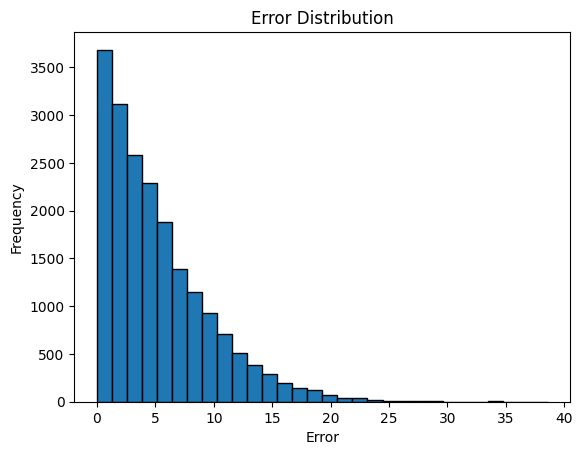

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df['ERROR'], bins=30, edgecolor='k')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()